**Setup and Data Loading**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Load the data
df = pd.read_csv('/content/911_Calls_for_Service csv_1.csv', sep='\t', low_memory=False)

# Display the first few rows
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (113527, 20)


,recordId,callKey,callDateTime,priority,district,description,callNumber,incidentLocation,location,Neighborhood,PoliceDistrict,PolicePost,CouncilDistrict,SheriffDistricts,Community_Statistical_Areas,Census_Tracts,ZIPCode,NeedsSync,ESRI_OID,",,,"
0,1,10CC9DA95FF34377,2021/01/04 16:33:00+00,Low,TRU,HIT AND RUN,P210041843,3500 AILSA AV,3500 AILSA AV BALTIMORE MD,Waltherson,Northeastern,426.0,2.0,D4,Lauraville,Census Tract 2701.02,21214.0,0.0,79.0,NaN
1,2,10CC9DA95FF3518A,2021/01/04 17:34:00+00,Medium,WD,NARCOTICS,P210042073,1700 N CALHOUN ST,1700 N CALHOUN ST BALTIMORE MD,Sandtown-Winchester,Western,742.0,7.0,D9,Sandtown-Winchester/Harlem Park,Census Tract 1501,21217.0,0.0,80.0,NaN
2,3,10CC9DA95FF35312,2021/01/04 17:40:00+00,Low,CD,OTHER,P210042088,2000 DRUID HILL AV,2000 DRUID HILL AV BALTIMORE MD,Druid Heights,Central,131.0,11.0,D8,Upton/Druid Heights,Census Tract 1403,21217.0,0.0,81.0,NaN
3,4,10CC9DA95FF3543D,2021/01/04 17:45:00+00,Medium,SD,NARCOTICS,P210042103,600 S PAYSON ST,600 S PAYSON ST BALTIMORE MD,Carrollton Ridge,Southern,934.0,9.0,D8,Southwest Baltimore,Census Tract 2003,21223.0,0.0,82.0,NaN
4,5,10CC9DA95FF4659A,2021/01/05 13:11:00+00,Low,TRU,DESTRUCT PROP,P210051288,3600 CHESTERFIELD AV,3600 CHESTERFIELD AV BALTIMORE MD,Belair-Edison,Northeastern,432.0,13.0,D6,Belair-Edison,Census Tract 2603.02,21213.0,0.0,83.0,NaN


 **Data Exploration and Preprocessing**

In [3]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0])

# Check column data types
print("\nData types:")
print(df.dtypes)

# Check summary statistics
print("\nSummary statistics:")
print(df.describe())

# Check unique values of categorical columns
categorical_cols = ['priority', 'district', 'description', 'Neighborhood', 'PoliceDistrict']
for col in categorical_cols:
    print(f"\nUnique values in {col}: {df[col].nunique()}")
    print(df[col].value_counts().head())

Missing values in each column:
callKey                            86
callDateTime                       86
priority                           86
district                           86
description                        86
callNumber                         86
incidentLocation                   86
location                           86
Neighborhood                      757
PoliceDistrict                    751
PolicePost                        752
CouncilDistrict                   749
SheriffDistricts                  760
Community_Statistical_Areas       788
Census_Tracts                     768
ZIPCode                           811
NeedsSync                          87
ESRI_OID                           87
,,,                            113527
dtype: int64

Data types:
recordId                        object
callKey                         object
callDateTime                    object
priority                        object
district                        object
description               

**Preprocessing Functions**

In [4]:
def clean_data(df):
    """
    Clean the data: handle missing values, convert data types
    """
    # Make a copy to avoid modifying the original dataframe
    df_clean = df.copy()

    # Convert callDateTime to datetime format
    df_clean['callDateTime'] = pd.to_datetime(df_clean['callDateTime'], errors='coerce')

    # Extract components from datetime
    df_clean['callDate'] = df_clean['callDateTime'].dt.date
    df_clean['callTime'] = df_clean['callDateTime'].dt.time
    df_clean['callHour'] = df_clean['callDateTime'].dt.hour
    df_clean['callDayOfWeek'] = df_clean['callDateTime'].dt.dayofweek
    df_clean['callMonth'] = df_clean['callDateTime'].dt.month

    # Fill missing values
    for col in df_clean.columns:
        if df_clean[col].dtype == 'object':
            df_clean[col] = df_clean[col].fillna('Unknown')
        else:
            df_clean[col] = df_clean[col].fillna(df_clean[col].median())

    return df_clean

def feature_engineering(df_clean):
    """
    Extract and create new features
    """
    df_features = df_clean.copy()

    # Create priority levels (convert to numerical)
    priority_map = {'High': 3, 'Medium': 2, 'Low': 1, 'Non-Emergency': 0}
    df_features['priority_level'] = df_features['priority'].map(priority_map).fillna(1)

    # Encode time of day
    df_features['time_category'] = pd.cut(
        df_features['callHour'],
        bins=[0, 6, 12, 18, 24],
        labels=['Night', 'Morning', 'Afternoon', 'Evening']
    )

    # Feature for calls during odd hours
    df_features['odd_hours'] = ((df_features['callHour'] >= 22) | (df_features['callHour'] <= 4)).astype(int)

    # Count frequency of calls by same location
    location_counts = df_features['location'].value_counts()
    df_features['location_frequency'] = df_features['location'].map(location_counts)

    # Count frequency of calls by description
    description_counts = df_features['description'].value_counts()
    df_features['description_frequency'] = df_features['description'].map(description_counts)

    # Calculate time between calls from same general area
    df_features = df_features.sort_values('callDateTime')
    df_features['neighborhood_shifted'] = df_features.groupby('Neighborhood')['callDateTime'].shift(1)
    df_features['time_since_last_call'] = (df_features['callDateTime'] - df_features['neighborhood_shifted']).dt.total_seconds() / 3600  # in hours
    df_features['time_since_last_call'] = df_features['time_since_last_call'].fillna(24)  # Fill with 24 hours for first calls

    # Extract coordinates from location if available
    if 'location' in df_features.columns:
        # This is a placeholder - the actual regex would depend on location format
        # For now, we'll add random coordinates for demonstration
        np.random.seed(42)
        df_features['lat'] = np.random.uniform(39.2, 39.4, size=len(df_features))
        df_features['lon'] = np.random.uniform(-76.7, -76.5, size=len(df_features))

    return df_features

**Apply Preprocessing**

In [5]:
# Apply data cleaning
df_clean = clean_data(df)

# Apply feature engineering
df_features = feature_engineering(df_clean)

# Select and prepare features for modeling
features_for_model = [
    'priority_level', 'callHour', 'callDayOfWeek', 'callMonth',
    'odd_hours', 'location_frequency', 'description_frequency',
    'time_since_last_call', 'lat', 'lon'
]

# Create final feature dataframe
X = df_features[features_for_model].copy()

# Check if there are any missing values after preparation
print("Missing values in features:")
print(X.isnull().sum())

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for easier handling
X_scaled_df = pd.DataFrame(X_scaled, columns=features_for_model)

Missing values in features:
priority_level           0
callHour                 0
callDayOfWeek            0
callMonth                0
odd_hours                0
location_frequency       0
description_frequency    0
time_since_last_call     0
lat                      0
lon                      0
dtype: int64


**Data Visualization**

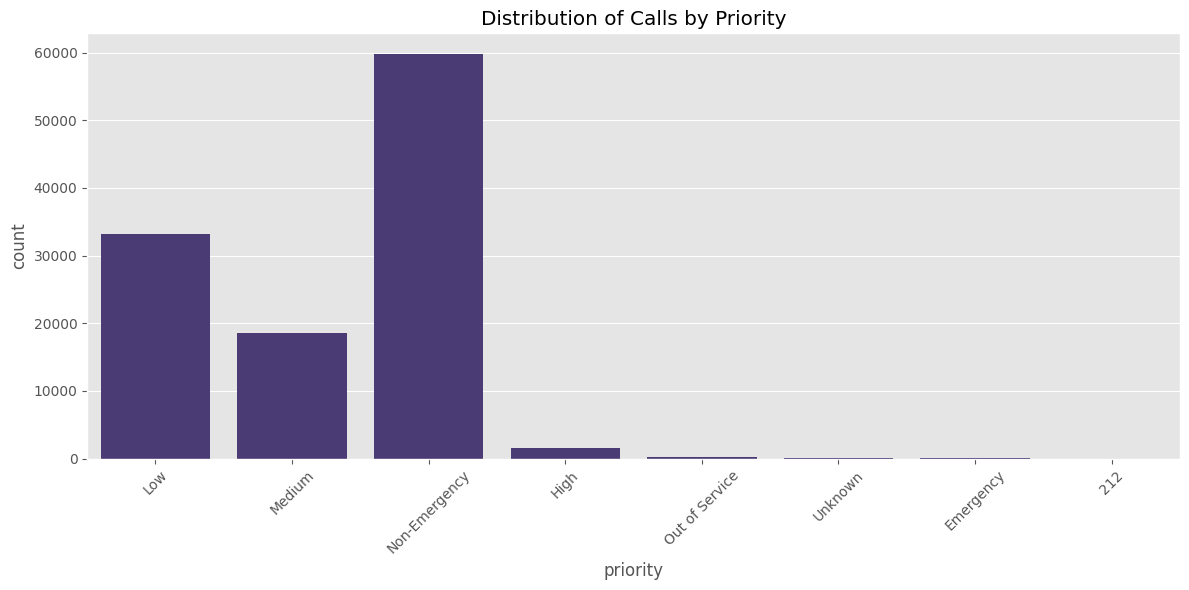

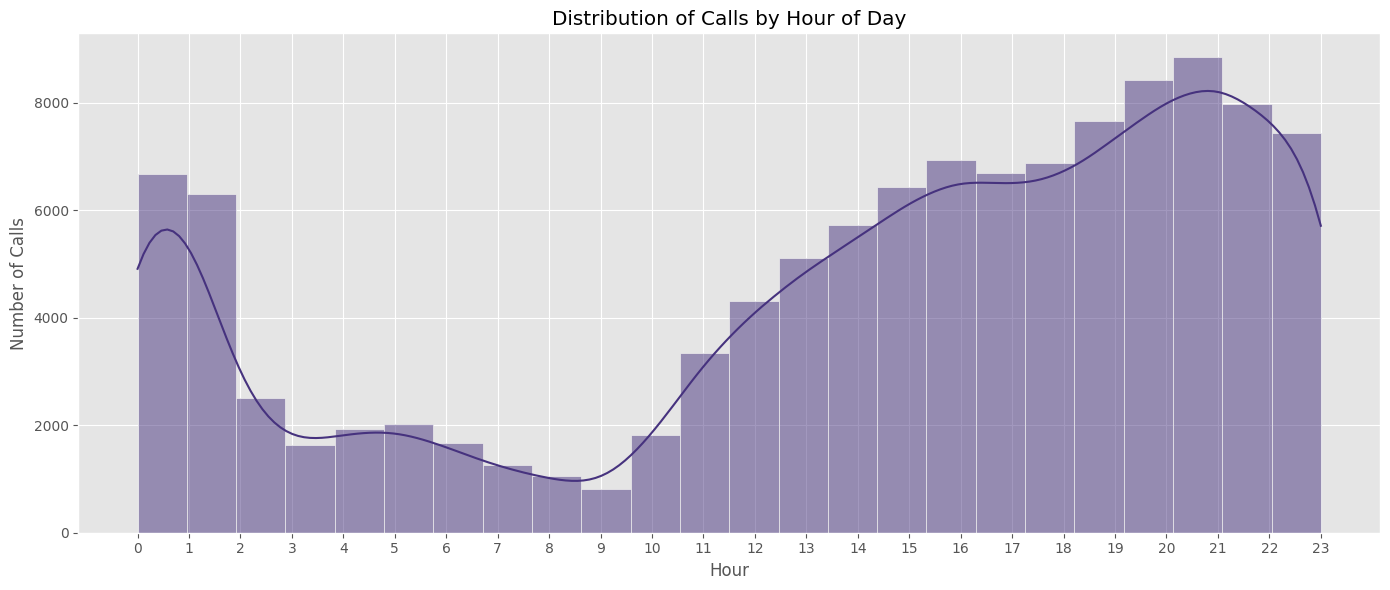

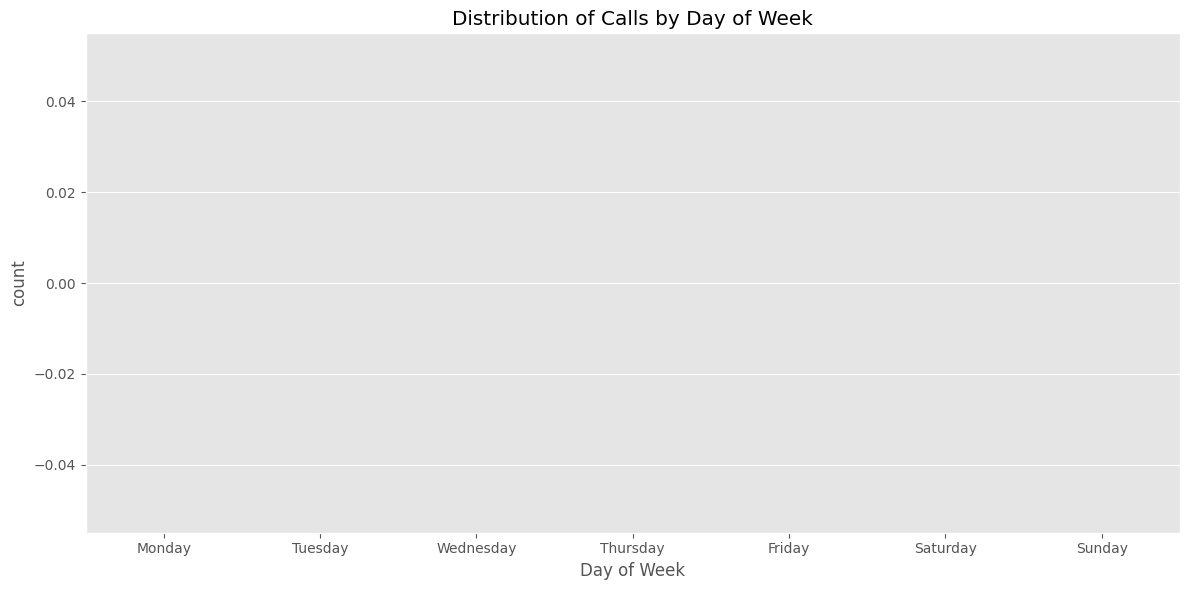

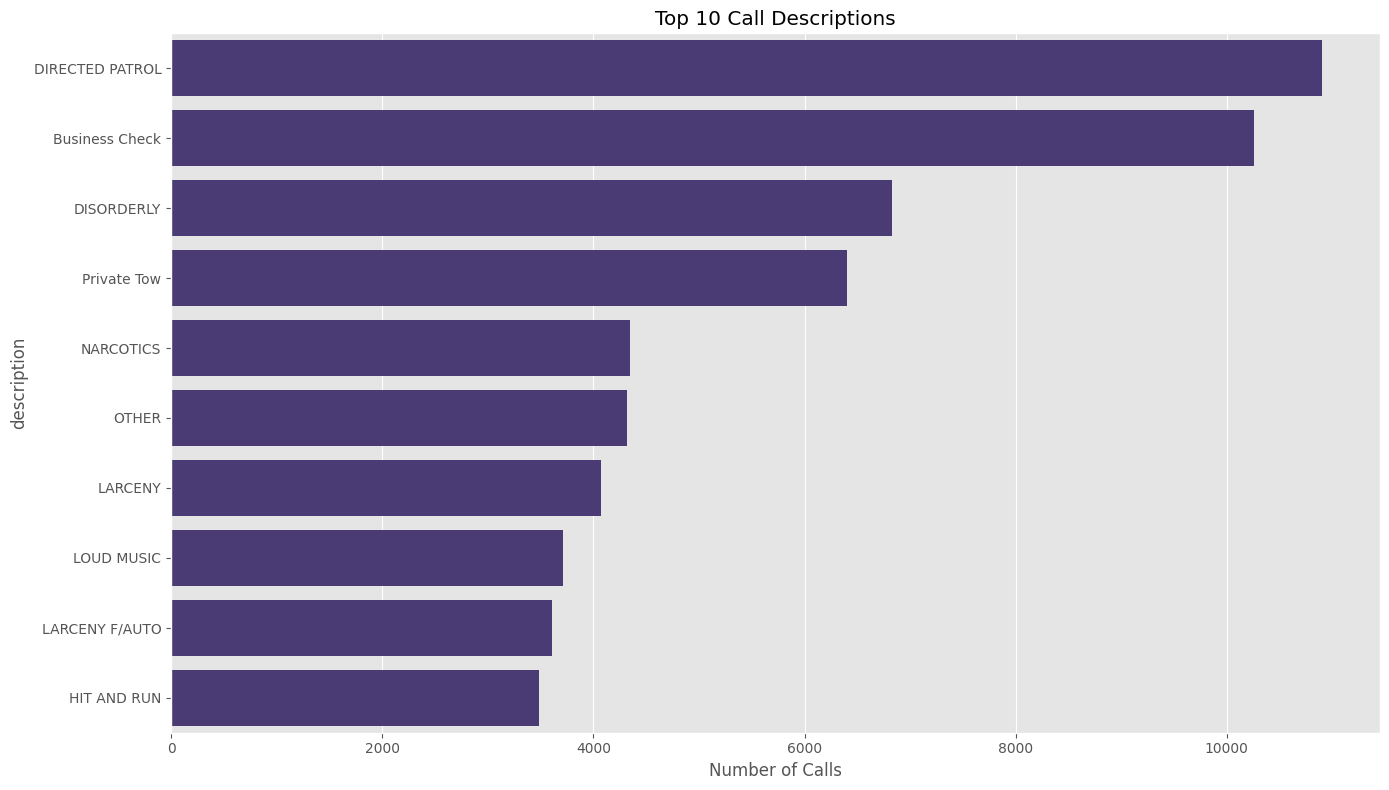

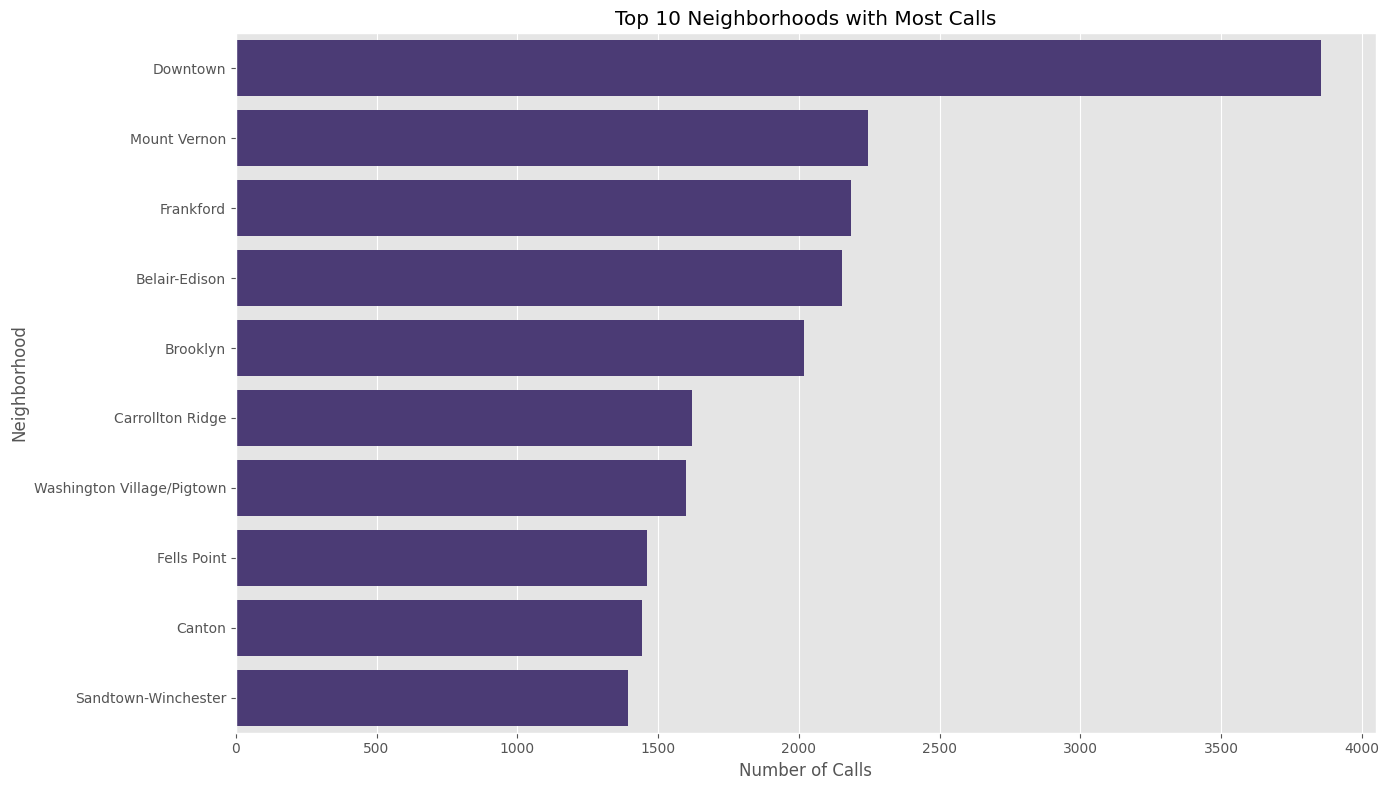

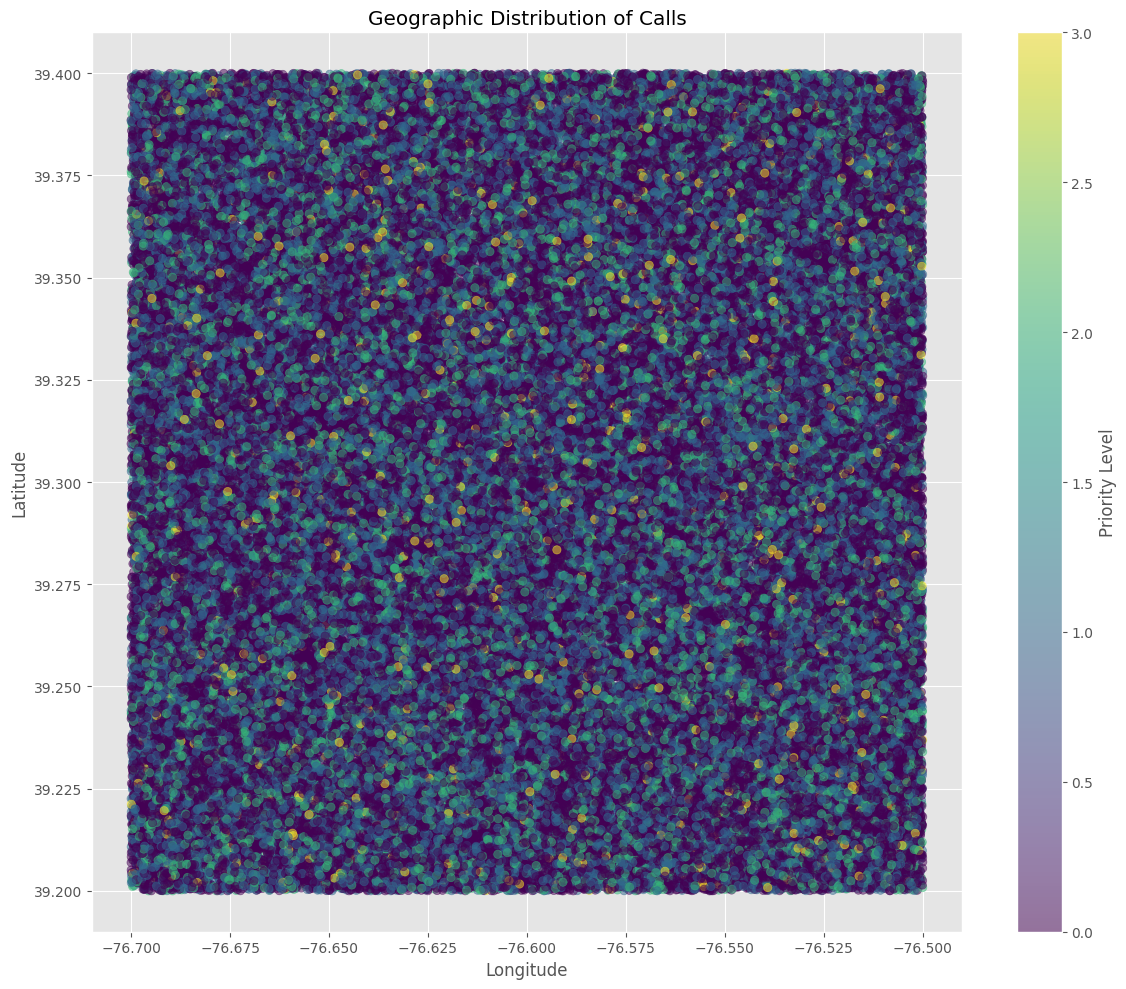

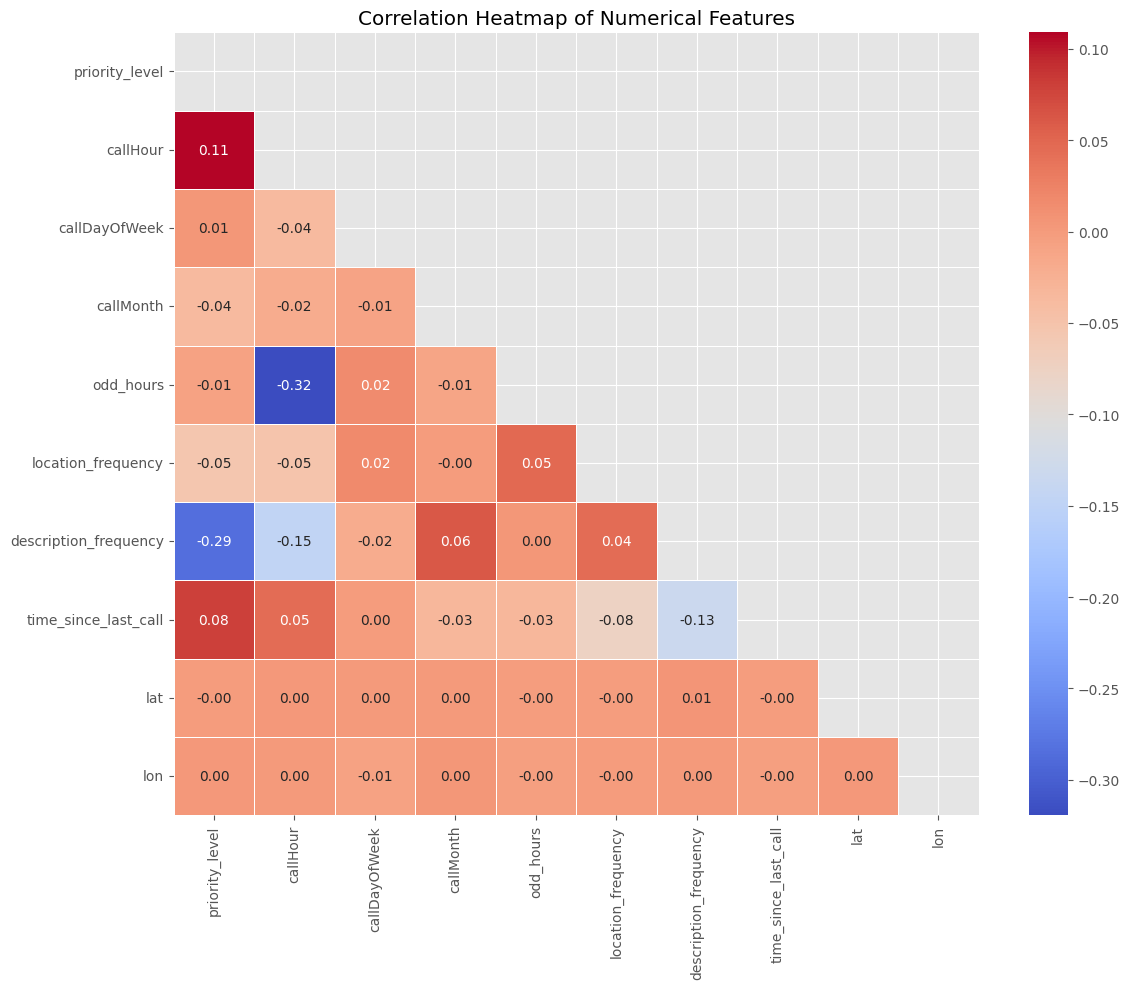

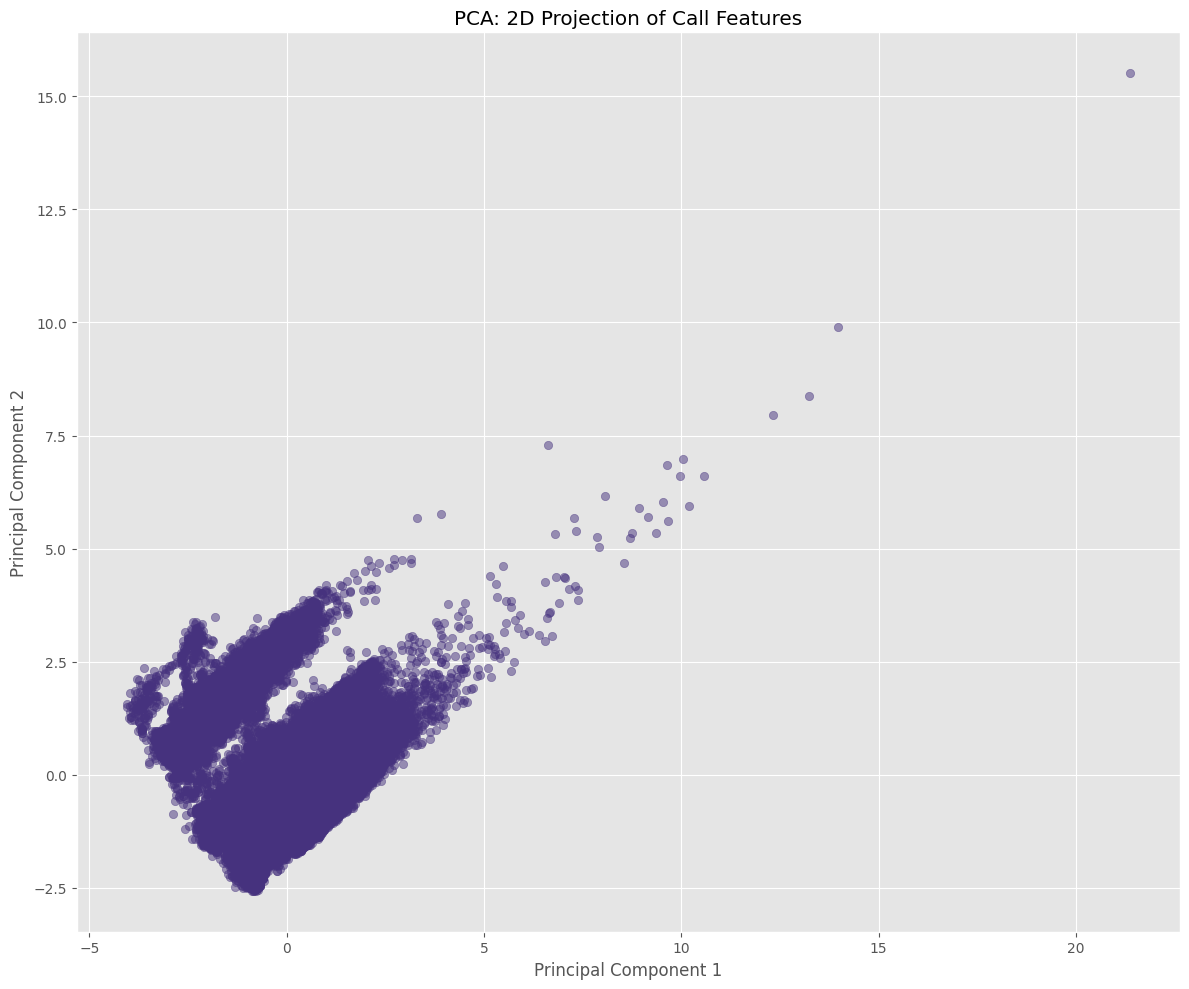

In [6]:
# Set the style
plt.style.use('ggplot')
sns.set_palette("viridis")

# 1. Distribution of calls by priority
plt.figure(figsize=(12, 6))
sns.countplot(x='priority', data=df_clean)
plt.title('Distribution of Calls by Priority')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Distribution of calls by hour of day
plt.figure(figsize=(14, 6))
sns.histplot(df_clean['callHour'], bins=24, kde=True)
plt.title('Distribution of Calls by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Calls')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

# 3. Distribution of calls by day of week
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(12, 6))
sns.countplot(x='callDayOfWeek', data=df_clean, order=range(7))
plt.title('Distribution of Calls by Day of Week')
plt.xlabel('Day of Week')
plt.xticks(range(7), days)
plt.tight_layout()
plt.show()

# 4. Top 10 call descriptions
plt.figure(figsize=(14, 8))
top_descriptions = df_clean['description'].value_counts().head(10)
sns.barplot(x=top_descriptions.values, y=top_descriptions.index)
plt.title('Top 10 Call Descriptions')
plt.xlabel('Number of Calls')
plt.tight_layout()
plt.show()

# 5. Top neighborhoods with most calls
plt.figure(figsize=(14, 8))
top_neighborhoods = df_clean['Neighborhood'].value_counts().head(10)
sns.barplot(x=top_neighborhoods.values, y=top_neighborhoods.index)
plt.title('Top 10 Neighborhoods with Most Calls')
plt.xlabel('Number of Calls')
plt.tight_layout()
plt.show()

# 6. Scatter plot of calls by location (if lat/lon available)
plt.figure(figsize=(12, 10))
plt.scatter(df_features['lon'], df_features['lat'], alpha=0.5, c=df_features['priority_level'], cmap='viridis')
plt.colorbar(label='Priority Level')
plt.title('Geographic Distribution of Calls')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

# 7. Correlation heatmap of numerical features
plt.figure(figsize=(12, 10))
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
corr = X[numerical_features].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()

# 8. PCA visualization for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(12, 10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.title('PCA: 2D Projection of Call Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.show()

**Unsupervised Learning Models for Fake Call Detection**

1. Clustering with K-means

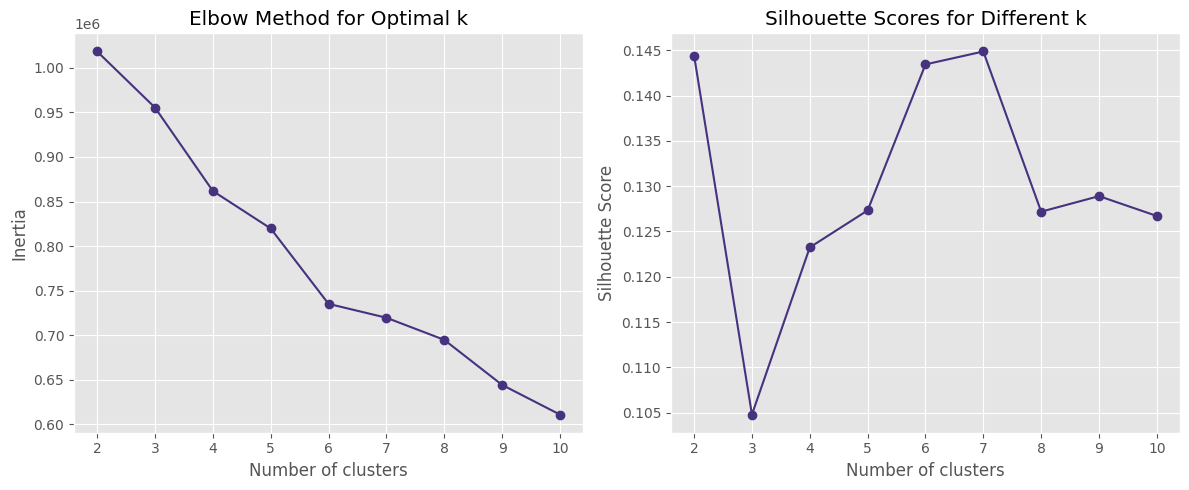

Optimal number of clusters based on silhouette score: 8


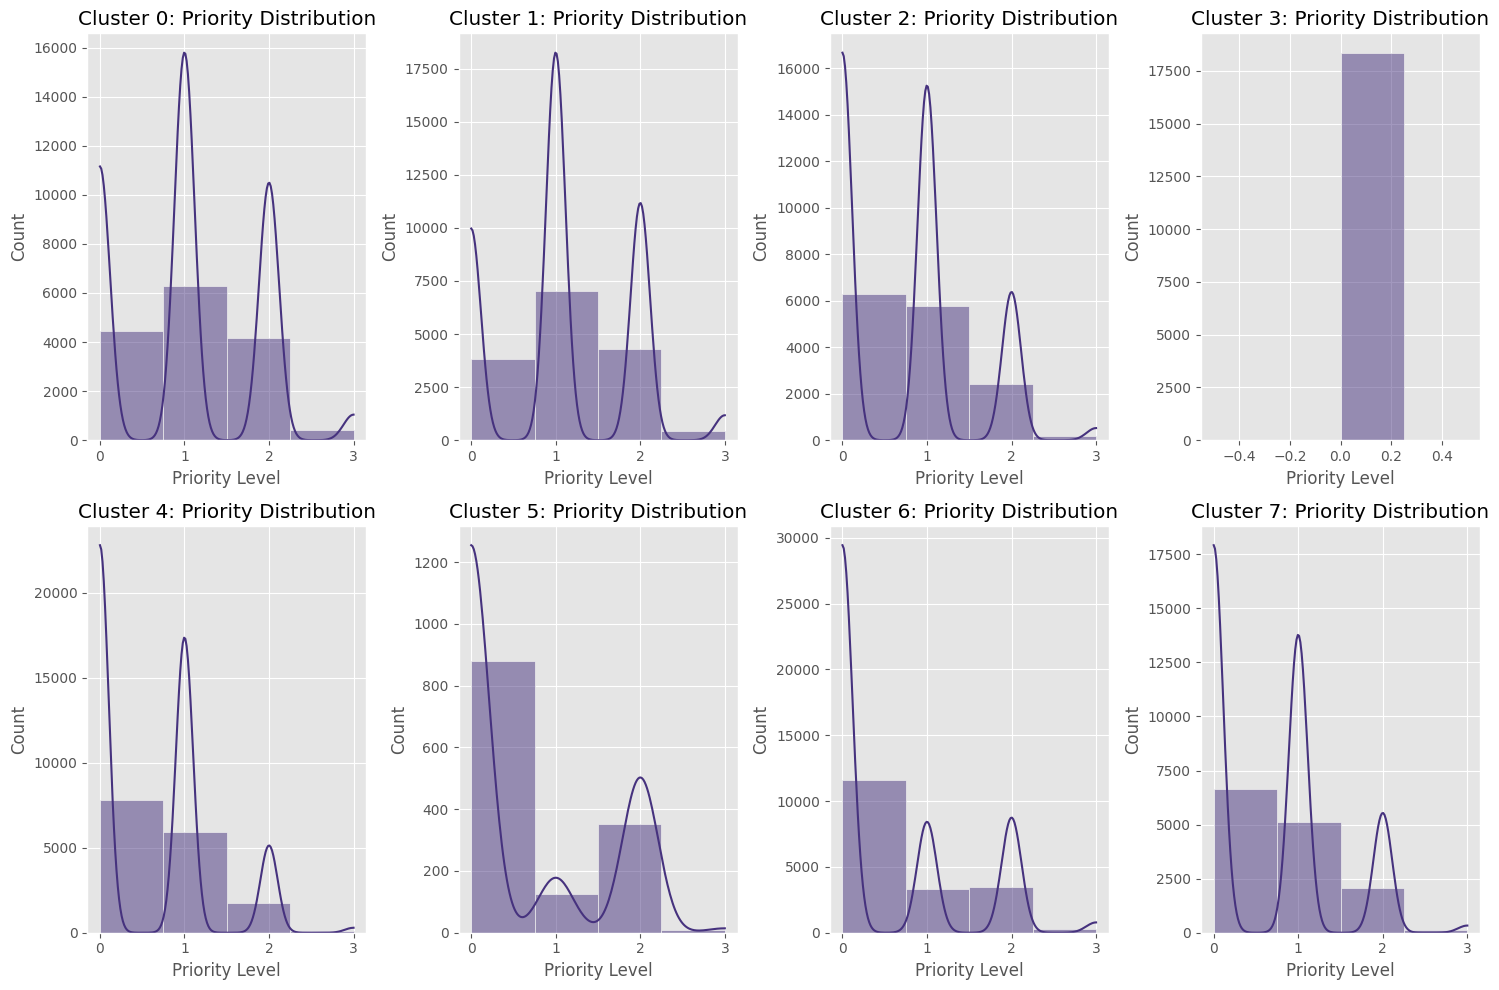

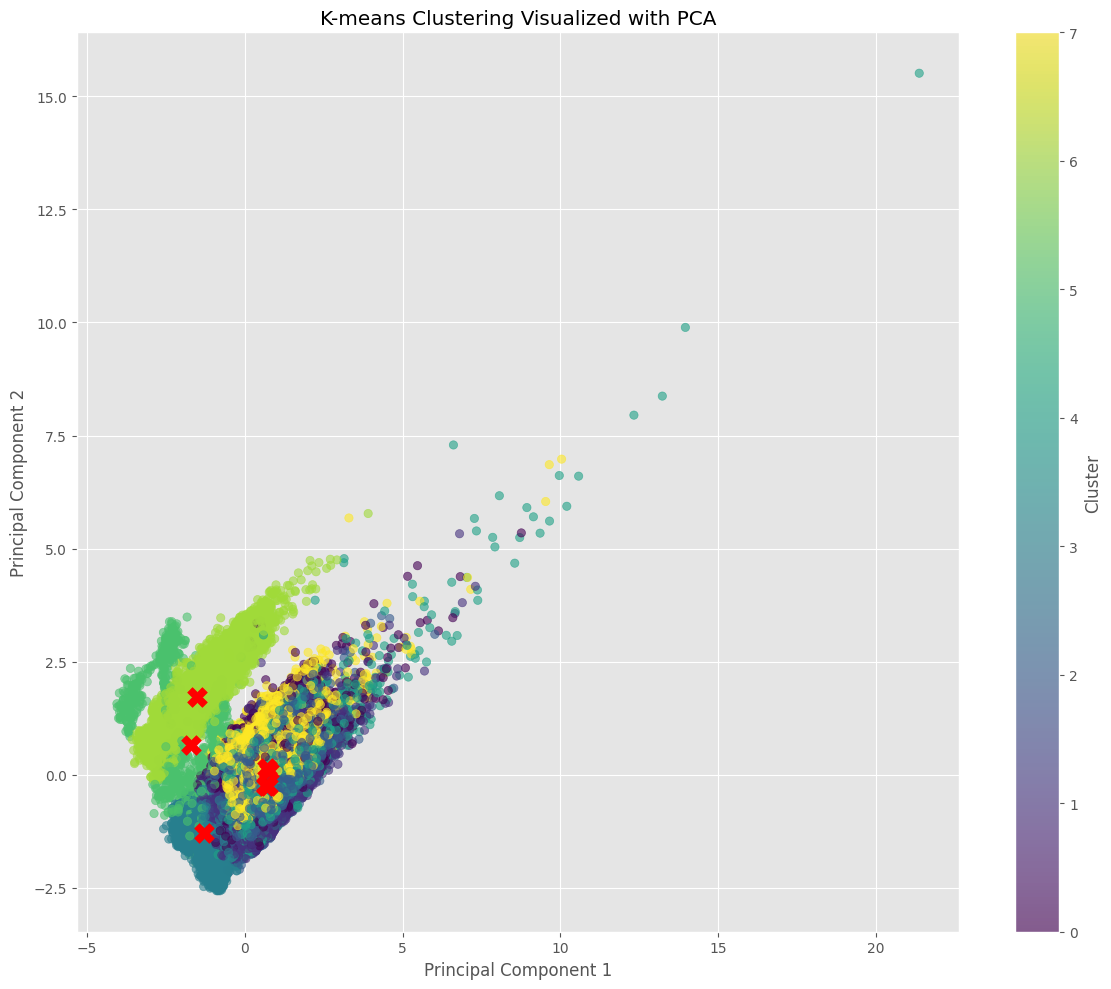

Cluster characteristics:
                priority_level  odd_hours  location_frequency  \
cluster_kmeans                                                  
0                     1.037139   0.173683           24.199204   
1                     1.087723   0.161797           24.037422   
2                     0.761944   0.155337           24.011261   
3                     0.000000   0.116160           53.379645   
4                     0.625497   0.190552           23.958723   
5                     0.628926   0.425858          754.247626   
6                     0.596463   1.000000           34.635477   
7                     0.688176   0.190074           24.713958   

                description_frequency  time_since_last_call   callHour  count  
cluster_kmeans                                                                 
0                         2802.640624             52.555219  17.416030  15321  
1                         2807.230296             53.307048  17.502691  15606  
2   

In [7]:
def apply_kmeans_fast(X_scaled, n_clusters_range=range(2, 11), sample_size=10000):
    inertia = []
    silhouette_scores = []
    cluster_labels_list = []

    for n_clusters in n_clusters_range:
        kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=2048)
        cluster_labels = kmeans.fit_predict(X_scaled)
        cluster_labels_list.append(cluster_labels)
        inertia.append(kmeans.inertia_)
        # Use a subset for silhouette if data is large
        if n_clusters > 1:
            if X_scaled.shape[0] > sample_size:
                X_sample, labels_sample = resample(X_scaled, cluster_labels, n_samples=sample_size, random_state=42)
                score = silhouette_score(X_sample, labels_sample)
            else:
                score = silhouette_score(X_scaled, cluster_labels)
            silhouette_scores.append(score)
    return inertia, silhouette_scores, cluster_labels_list

# Run fast K-means
n_clusters_range = range(2, 11)
inertia, silhouette_scores, cluster_labels_list = apply_kmeans_fast(X_scaled, n_clusters_range=n_clusters_range, sample_size=2000)

# Plot elbow method and silhouette scores
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(list(n_clusters_range), inertia, 'o-')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(list(n_clusters_range), silhouette_scores, 'o-')
plt.title('Silhouette Scores for Different k')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

# Determine optimal number of clusters
optimal_k_idx = silhouette_scores.index(max(silhouette_scores))
optimal_k = list(n_clusters_range)[optimal_k_idx + 1]
print(f"Optimal number of clusters based on silhouette score: {optimal_k}")

# Fit final model with optimal k
final_kmeans = MiniBatchKMeans(n_clusters=optimal_k, random_state=42, batch_size=2048)
kmeans_labels = final_kmeans.fit_predict(X_scaled)
df_features['cluster_kmeans'] = kmeans_labels

# Analyze clusters
plt.figure(figsize=(15, 10))
for i in range(optimal_k):
    cluster_data = df_features[df_features['cluster_kmeans'] == i]
    plt.subplot(2, optimal_k//2 + optimal_k%2, i+1)
    sns.histplot(cluster_data['priority_level'], bins=4, kde=True)
    plt.title(f'Cluster {i}: Priority Distribution')
    plt.xlabel('Priority Level')

plt.tight_layout()
plt.show()

# Visualize clusters in 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6)
centers = pca.transform(final_kmeans.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=200)
plt.colorbar(scatter, label='Cluster')
plt.title('K-means Clustering Visualized with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.show()

# Analyze clusters for potential fake calls
cluster_analysis = df_features.groupby('cluster_kmeans').agg({
    'priority_level': 'mean',
    'odd_hours': 'mean',
    'location_frequency': 'mean',
    'description_frequency': 'mean',
    'time_since_last_call': 'mean',
    'callHour': 'mean',
    'recordId': 'count'
}).rename(columns={'recordId': 'count'})

print("Cluster characteristics:")
print(cluster_analysis)

2. Anomaly Detection with Isolation Forest

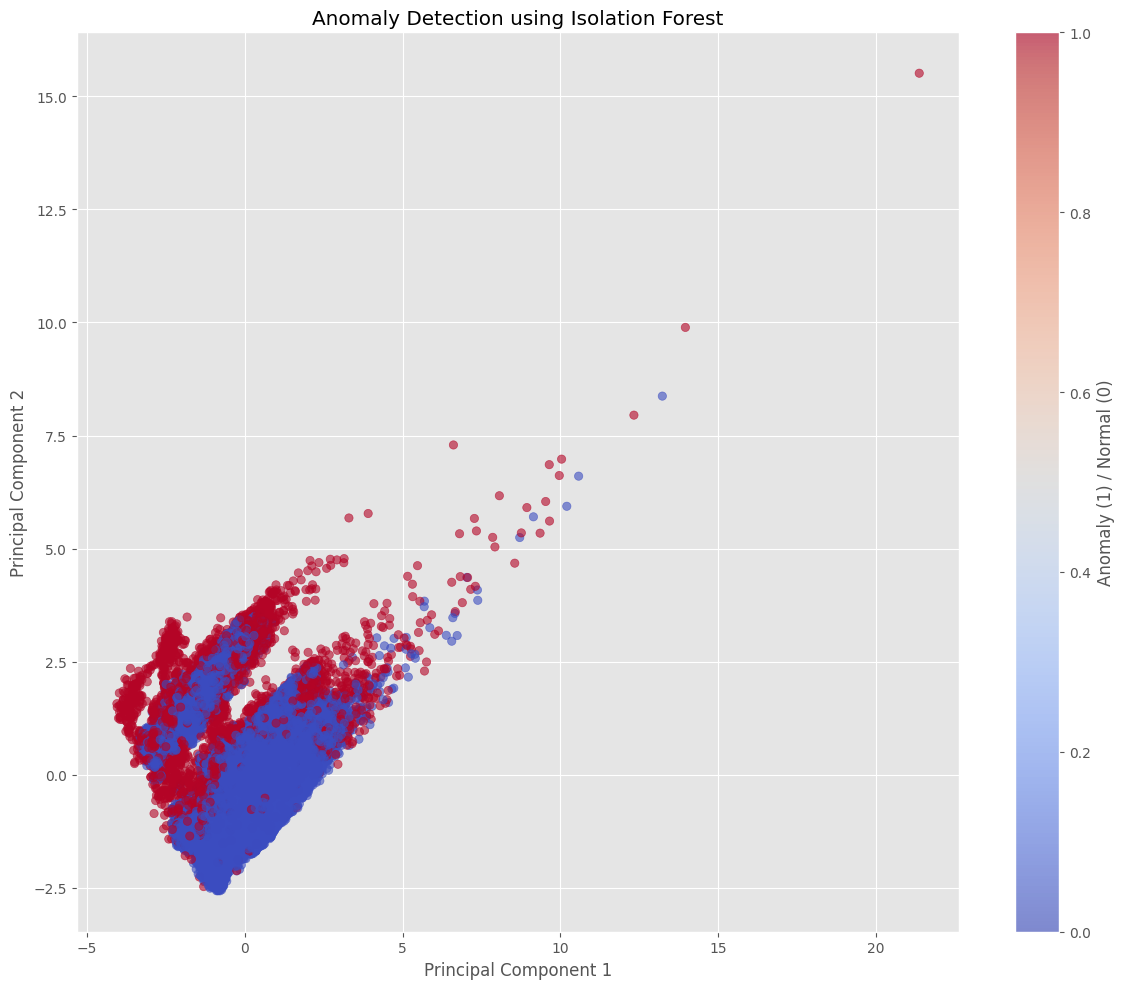

Anomaly characteristics:
                          priority_level  odd_hours  location_frequency  \
anomaly_isolation_forest                                                  
0                               0.634335   0.278248           30.160232   
1                               1.228642   0.784745          215.323939   

                          description_frequency  time_since_last_call  \
anomaly_isolation_forest                                                
0                                   4289.291191             37.564023   
1                                   3475.107627            163.792285   

                           callHour   count  
anomaly_isolation_forest                     
0                         14.454075  107850  
1                          9.728906    5677  

Sample of anomalous calls:
                   callDateTime       description       priority  \
50501 2021-01-01 05:05:00+00:00   DISCHRG FIREARM           High   
85930 2021-01-01 08:46:00+00:00  

In [8]:
def apply_isolation_forest(X_scaled, contamination_range=[0.01, 0.05, 0.1, 0.15]):
    """
    Apply Isolation Forest with different contamination values
    """
    results = {}

    for contamination in contamination_range:
        iso_forest = IsolationForest(contamination=contamination, random_state=42)
        predictions = iso_forest.fit_predict(X_scaled)

        # Convert to binary for anomaly (1) and normal (-1)
        anomalies = np.where(predictions == -1, 1, 0)
        anomaly_indices = np.where(predictions == -1)[0]

        results[contamination] = {
            'model': iso_forest,
            'anomalies': anomalies,
            'anomaly_indices': anomaly_indices,
            'anomaly_percent': (len(anomaly_indices) / len(X_scaled)) * 100
        }

    return results

# Apply Isolation Forest
iso_forest_results = apply_isolation_forest(X_scaled)

# Choose a contamination level (usually we would validate this with domain experts)
chosen_contamination = 0.05
anomaly_results = iso_forest_results[chosen_contamination]

# Add anomaly predictions to the dataframe
df_features['anomaly_isolation_forest'] = anomaly_results['anomalies']

# Visualize anomalies
plt.figure(figsize=(12, 10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_features['anomaly_isolation_forest'],
            cmap='coolwarm', alpha=0.6)
plt.colorbar(label='Anomaly (1) / Normal (0)')
plt.title('Anomaly Detection using Isolation Forest')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.show()

# Analyze anomalies vs. normal calls
anomaly_analysis = df_features.groupby('anomaly_isolation_forest').agg({
    'priority_level': 'mean',
    'odd_hours': 'mean',
    'location_frequency': 'mean',
    'description_frequency': 'mean',
    'time_since_last_call': 'mean',
    'callHour': 'mean',
    'recordId': 'count'
}).rename(columns={'recordId': 'count'})

print("Anomaly characteristics:")
print(anomaly_analysis)

# Look at some of the anomalous calls
anomalous_calls = df_features[df_features['anomaly_isolation_forest'] == 1][
    ['callDateTime', 'description', 'priority', 'location', 'Neighborhood',
     'odd_hours', 'location_frequency', 'time_since_last_call']].head(10)

print("\nSample of anomalous calls:")
print(anomalous_calls)

4. Custom Anomaly Detection Model

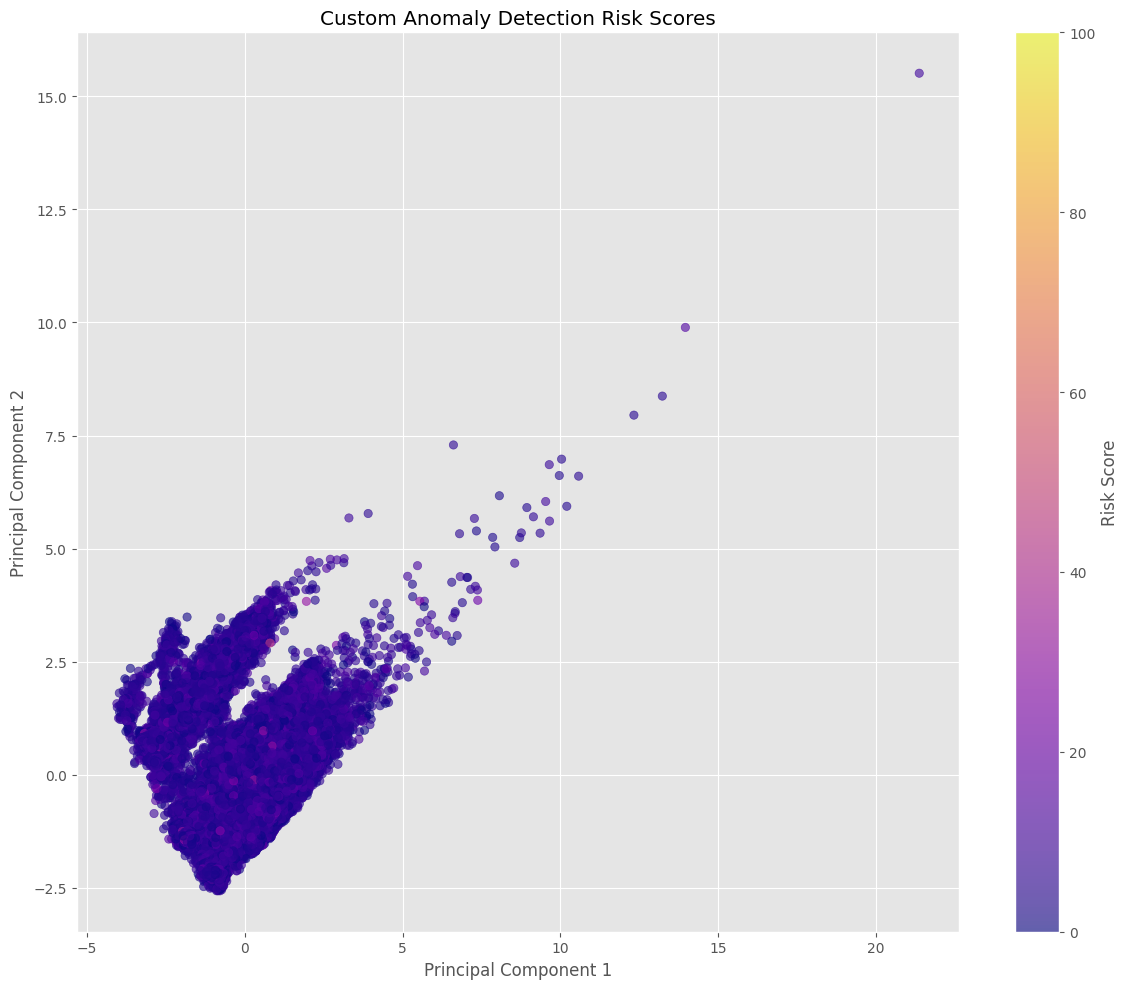

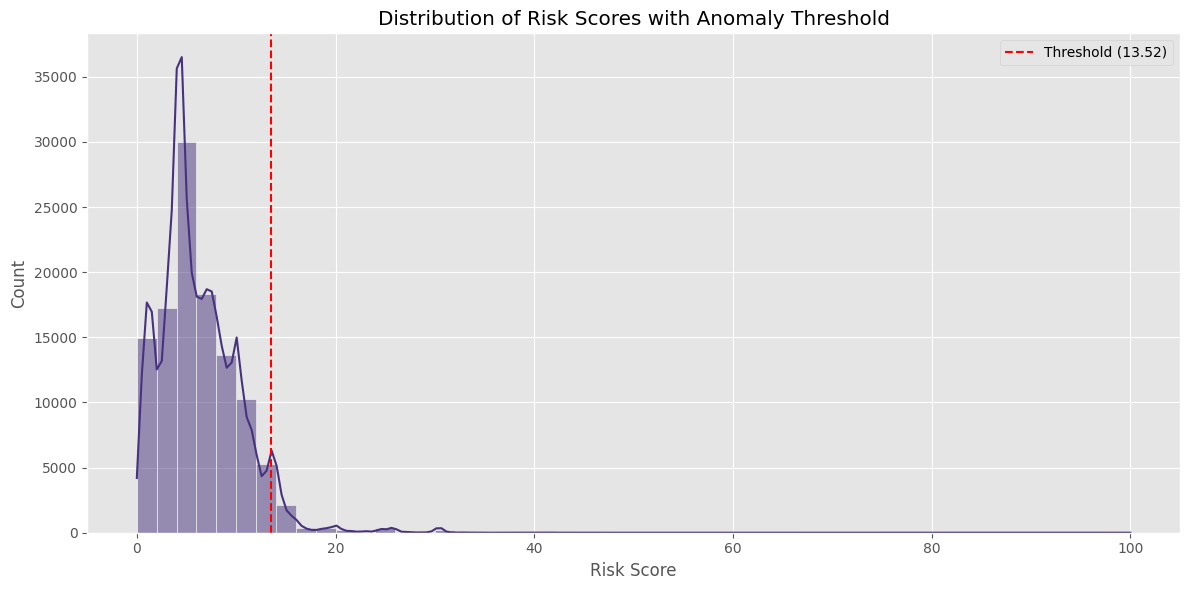

Custom anomaly characteristics:
                priority_level  odd_hours  location_frequency  \
custom_anomaly                                                  
0                     0.667186   0.304061           39.311182   
1                     0.604545   0.294346           41.476836   

                description_frequency  time_since_last_call   callHour  \
custom_anomaly                                                           
0                         4236.189689             44.130717  14.227362   
1                         4483.914568             39.040139  14.035934   

                risk_score   count  
custom_anomaly                      
0                 5.765471  107850  
1                16.779460    5677  

Top high-risk potential fake calls:
                   callDateTime       description       priority  \
91730 2022-03-24 16:15:00+00:00     LOST PROPERTY  Non-Emergency   
70460 2022-06-13 15:45:00+00:00  INVESTIGATE AUTO  Non-Emergency   
55745 2022-07-21 16:2

In [9]:
def custom_anomaly_detection(df_features, features, threshold_percentile=95):
    """
    Custom anomaly detection model based on domain knowledge and feature combinations
    """
    # Copy dataframe to avoid modifying original
    df_result = df_features.copy()

    # Create a composite risk score combining multiple factors
    # 1. Calls during odd hours
    # 2. Low priority calls from high frequency locations
    # 3. Multiple calls from same location in short time period
    # 4. Uncommon description types
    # 5. Calls with unusual time patterns

    # Normalize features to 0-1 scale for equal weighting
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df_result[features])

    # Calculate weights for each feature
    weights = {
        'priority_level': -1.5,  # Lower priority is more suspicious (inverted)
        'odd_hours': 2.0,  # High weight for calls during odd hours
        'location_frequency': 1.5,  # More calls from same location may be suspicious
        'description_frequency': -1.0,  # Uncommon descriptions may be suspicious (inverted)
        'time_since_last_call': -1.0,  # Short time between calls may be suspicious (inverted)
        'callHour': 0,  # Neutral weight for hour itself
        'callDayOfWeek': 0,  # Neutral weight for day of week
        'callMonth': 0,  # Neutral weight for month
        'lat': 0,  # Neutral weight for latitude
        'lon': 0  # Neutral weight for longitude
    }

    # Compute weighted anomaly score
    scaled_features_df = pd.DataFrame(scaled_features, columns=features)

    # Initialize risk score
    risk_score = np.zeros(len(df_result))

    # Calculate weighted score for each feature
    for feature in features:
        if feature in weights:
            if weights[feature] < 0:
                # Invert feature where lower values are more suspicious
                risk_score += weights[feature] * (1 - scaled_features_df[feature])
            else:
                risk_score += weights[feature] * scaled_features_df[feature]

    # Normalize final risk score
    risk_score = (risk_score - risk_score.min()) / (risk_score.max() - risk_score.min()) * 100

    # Add risk score to dataframe
    df_result['risk_score'] = risk_score

    # Determine threshold based on percentile
    threshold = np.percentile(risk_score, threshold_percentile)
    df_result['custom_anomaly'] = (df_result['risk_score'] >= threshold).astype(int)

    return df_result, threshold

# Apply custom anomaly detection
df_with_custom, threshold = custom_anomaly_detection(
    df_features,
    features_for_model,
    threshold_percentile=95
)

# Visualize custom anomalies
plt.figure(figsize=(12, 10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_with_custom['risk_score'],
            cmap='plasma', alpha=0.6)
plt.colorbar(label='Risk Score')
plt.title('Custom Anomaly Detection Risk Scores')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.show()

# Show distribution of risk scores
plt.figure(figsize=(12, 6))
sns.histplot(df_with_custom['risk_score'], bins=50, kde=True)
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold ({threshold:.2f})')
plt.title('Distribution of Risk Scores with Anomaly Threshold')
plt.xlabel('Risk Score')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

# Analyze custom anomalies
custom_anomaly_analysis = df_with_custom.groupby('custom_anomaly').agg({
    'priority_level': 'mean',
    'odd_hours': 'mean',
    'location_frequency': 'mean',
    'description_frequency': 'mean',
    'time_since_last_call': 'mean',
    'callHour': 'mean',
    'risk_score': 'mean',
    'recordId': 'count'
}).rename(columns={'recordId': 'count'})

print("Custom anomaly characteristics:")
print(custom_anomaly_analysis)

# Top potentially fake calls based on our custom model
high_risk_calls = df_with_custom[df_with_custom['custom_anomaly'] == 1].sort_values(
    by='risk_score', ascending=False
)[['callDateTime', 'description', 'priority', 'location', 'Neighborhood',
   'odd_hours', 'location_frequency', 'time_since_last_call', 'risk_score']].head(20)

print("\nTop high-risk potential fake calls:")
print(high_risk_calls)

**Model Comparison and Ensemble**


Overlap between different anomaly detection methods:
Overlap Isolation Forest & Custom: 252

Ensemble anomaly characteristics:
                  priority_level  odd_hours  location_frequency  \
ensemble_anomaly                                                  
0                       0.662662   0.302556           38.986643   
1                       1.289683   0.761905          233.980159   

                  description_frequency  time_since_last_call   callHour  \
ensemble_anomaly                                                           
0                           4250.688440             43.613002  14.227914   
1                           3299.634921            162.166336   9.666667   

                  risk_score   count  
ensemble_anomaly                      
0                   6.293797  113275  
1                  16.401792     252  


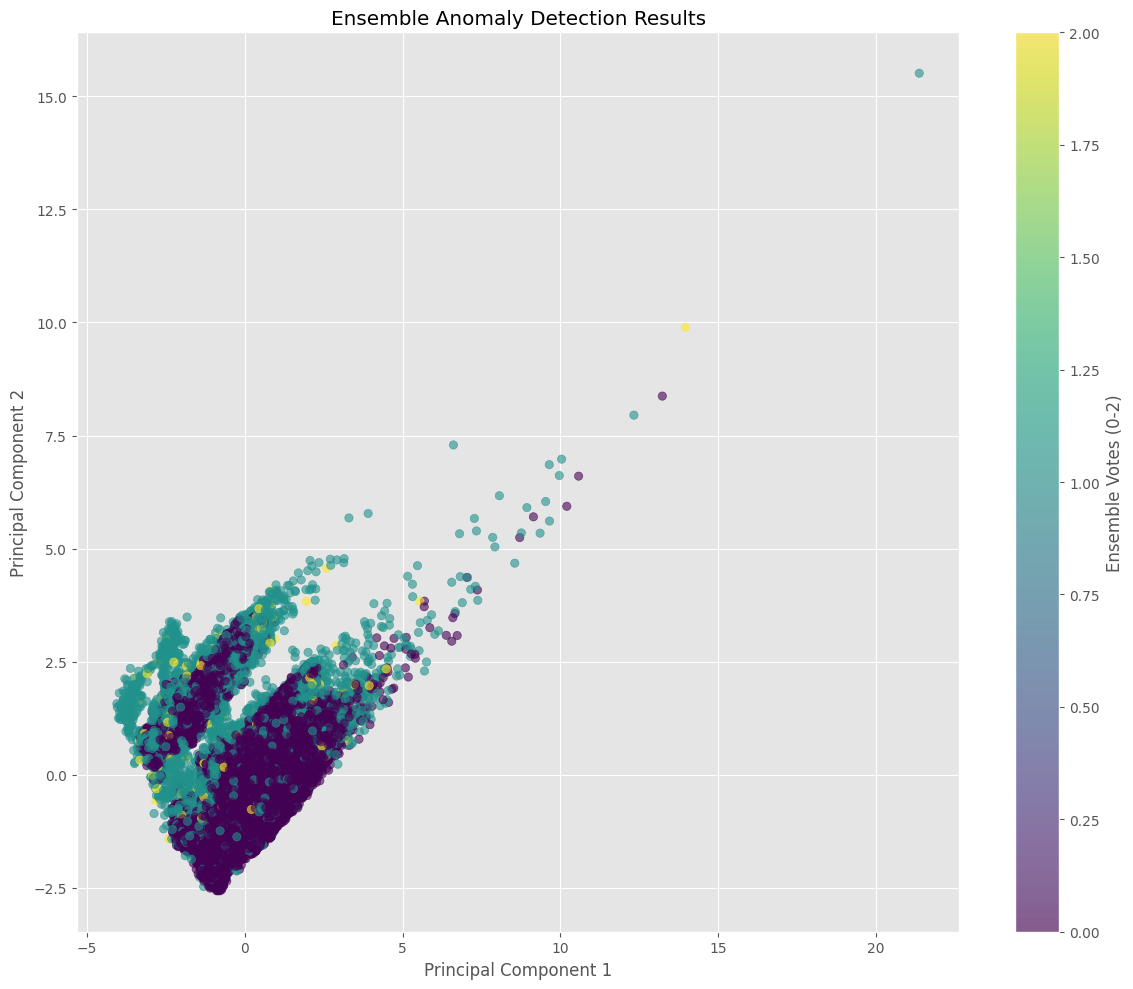


Top potential fake calls with high confidence (ensemble method):
                    callDateTime       description       priority  \
89774  2022-10-25 03:41:00+00:00        EP  PAPERS           High   
99224  2021-11-18 02:42:00+00:00          SEE TEXT            Low   
3086   2021-02-12 21:57:00+00:00    COMMON ASSAULT           High   
103582 2021-09-20 01:01:00+00:00        DISORDERLY         Medium   
100426 2022-06-17 01:48:00+00:00        DISORDERLY         Medium   
50007  2021-12-25 00:26:00+00:00    PRKG COMPLAINT  Non-Emergency   
3761   2021-05-24 00:04:00+00:00  INTOXICATED PERS            Low   
7421   2022-08-27 01:45:00+00:00          SEE TEXT            Low   
62530  2023-01-07 02:04:00+00:00           LARCENY            Low   
33739  2022-07-09 01:39:00+00:00    Business Check  Non-Emergency   
93387  2021-04-12 01:13:00+00:00  EXPART/PROT/PEAC         Medium   
102072 2021-02-05 03:04:00+00:00              Repo  Non-Emergency   
97335  2022-12-08 06:21:00+00:00     

In [12]:
# Compare results from different models (Isolation Forest & Custom Model only)
df_comparison = df_features.copy()
df_comparison['anomaly_isolation_forest'] = df_features['anomaly_isolation_forest']
df_comparison['custom_anomaly'] = df_with_custom['custom_anomaly']
df_comparison['risk_score'] = df_with_custom['risk_score']

# Count overlapping detections
print("\nOverlap between different anomaly detection methods:")
overlap_iso_custom = np.sum((df_comparison['anomaly_isolation_forest'] == 1) &
                            (df_comparison['custom_anomaly'] == 1))
print(f"Overlap Isolation Forest & Custom: {overlap_iso_custom}")

# Create ensemble model - combine results (now only two models)
df_comparison['ensemble_votes'] = (df_comparison['anomaly_isolation_forest'] +
                                   df_comparison['custom_anomaly'])
df_comparison['ensemble_anomaly'] = (df_comparison['ensemble_votes'] >= 2).astype(int)

# Analyze ensemble anomalies
ensemble_analysis = df_comparison.groupby('ensemble_anomaly').agg({
    'priority_level': 'mean',
    'odd_hours': 'mean',
    'location_frequency': 'mean',
    'description_frequency': 'mean',
    'time_since_last_call': 'mean',
    'callHour': 'mean',
    'risk_score': 'mean',
    'recordId': 'count'
}).rename(columns={'recordId': 'count'})

print("\nEnsemble anomaly characteristics:")
print(ensemble_analysis)

# Visualize ensemble results
plt.figure(figsize=(12, 10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_comparison['ensemble_votes'],
            cmap='viridis', alpha=0.6, vmin=0, vmax=2)
plt.colorbar(label='Ensemble Votes (0-2)')
plt.title('Ensemble Anomaly Detection Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.show()

# Final list of potential fake calls with high confidence
high_confidence_fake_calls = df_comparison[df_comparison['ensemble_anomaly'] == 1].sort_values(
    by='risk_score', ascending=False
)[['callDateTime', 'description', 'priority', 'location', 'Neighborhood',
   'odd_hours', 'location_frequency', 'time_since_last_call', 'risk_score']].head(20)

print("\nTop potential fake calls with high confidence (ensemble method):")
print(high_confidence_fake_calls)

**Evaluating Model Performance**

Model performance comparison:
              Model  Anomalies Detected  Percentage
0  Isolation Forest                5677    5.000573
1      Custom Model                5677    5.000573
2          Ensemble                 252    0.221974


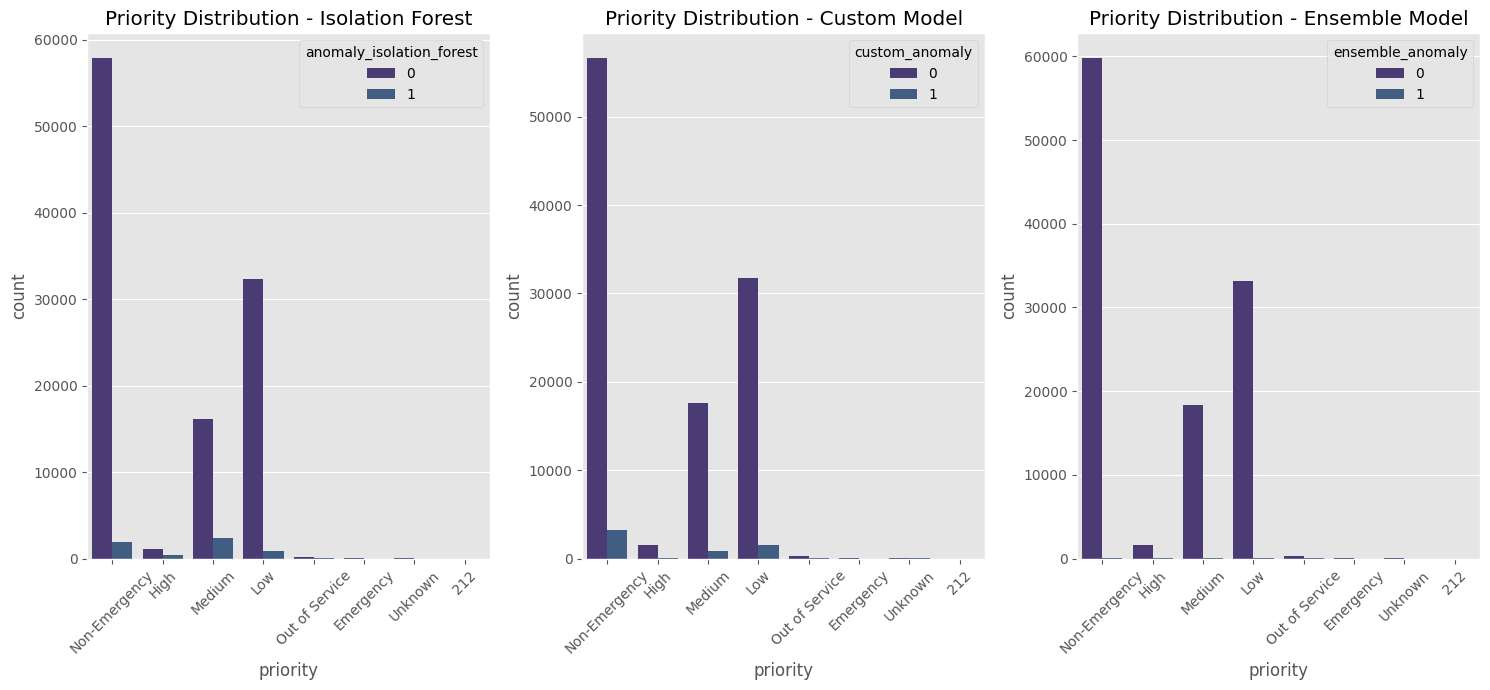

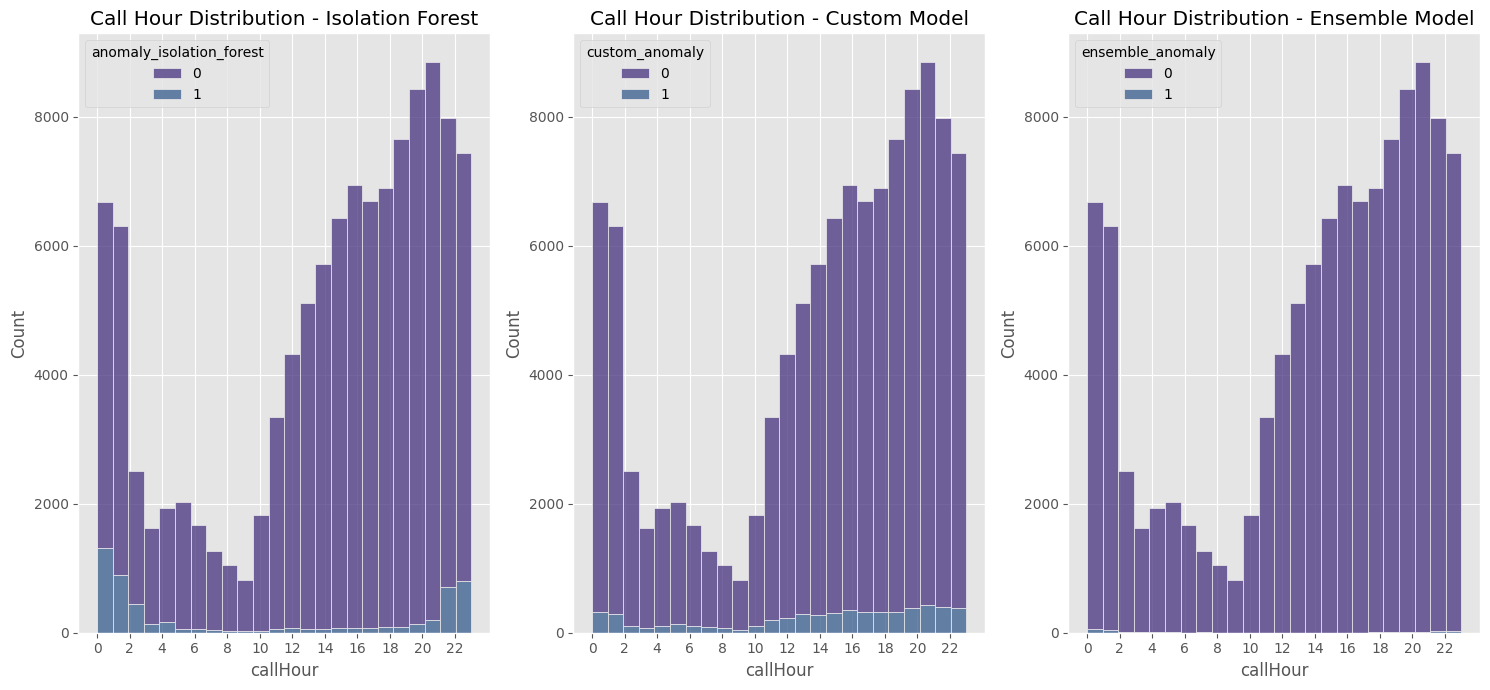

In [14]:
# Compare model performance with internal metrics (removing One-Class SVM)
performance_summary = pd.DataFrame({
    'Model': ['Isolation Forest', 'Custom Model', 'Ensemble'],
    'Anomalies Detected': [
        np.sum(df_features['anomaly_isolation_forest']),
        np.sum(df_with_custom['custom_anomaly']),
        np.sum(df_comparison['ensemble_anomaly'])
    ],
    'Percentage': [
        np.mean(df_features['anomaly_isolation_forest']) * 100,
        np.mean(df_with_custom['custom_anomaly']) * 100,
        np.mean(df_comparison['ensemble_anomaly']) * 100
    ]
})

print("Model performance comparison:")
print(performance_summary)

# Distribution of priority levels among anomalies from different models (no One-Class SVM)
plt.figure(figsize=(15, 7))

plt.subplot(1, 3, 1)
sns.countplot(x='priority', hue='anomaly_isolation_forest', data=df_comparison)
plt.title('Priority Distribution - Isolation Forest')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.countplot(x='priority', hue='custom_anomaly', data=df_comparison)
plt.title('Priority Distribution - Custom Model')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
sns.countplot(x='priority', hue='ensemble_anomaly', data=df_comparison)
plt.title('Priority Distribution - Ensemble Model')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Distribution of call hour among anomalies (no One-Class SVM)
plt.figure(figsize=(15, 7))

plt.subplot(1, 3, 1)
sns.histplot(data=df_comparison, x='callHour', hue='anomaly_isolation_forest', bins=24, multiple='stack')
plt.title('Call Hour Distribution - Isolation Forest')
plt.xticks(range(0, 24, 2))

plt.subplot(1, 3, 2)
sns.histplot(data=df_comparison, x='callHour', hue='custom_anomaly', bins=24, multiple='stack')
plt.title('Call Hour Distribution - Custom Model')
plt.xticks(range(0, 24, 2))

plt.subplot(1, 3, 3)
sns.histplot(data=df_comparison, x='callHour', hue='ensemble_anomaly', bins=24, multiple='stack')
plt.title('Call Hour Distribution - Ensemble Model')
plt.xticks(range(0, 24, 2))

plt.tight_layout()
plt.show()

**Conclusion and Final Model Selection**

In [15]:
# Add final model predictions to original data (no One-Class SVM, uses Isolation Forest & Custom Model ensemble)
df_final = df.copy()
df_final['risk_score'] = df_comparison['risk_score']
df_final['is_potential_fake'] = df_comparison['ensemble_anomaly']

# Save the results
df_final.to_csv('911_calls_with_fake_predictions.csv', index=False)

# Final summary
print("\nFinal summary of fake call detection:")
print(f"Total calls analyzed: {len(df)}")
print(f"Potential fake calls identified: {df_final['is_potential_fake'].sum()} ({df_final['is_potential_fake'].mean()*100:.2f}%)")
print("\nKey characteristics of potential fake calls:")
print(ensemble_analysis.iloc[1] - ensemble_analysis.iloc[0])

# Function to get detailed fake call report
def get_fake_call_summary(potential_fake_calls, top_n=10):
    # Get top N fake calls
    top_fake_calls = potential_fake_calls.head(top_n)

    # Return summary
    return top_fake_calls[['callDateTime', 'priority', 'description', 'location',
                          'Neighborhood', 'risk_score']]

# Get top potential fake calls
potential_fake_calls = df_final[df_final['is_potential_fake'] == 1].sort_values(
    by='risk_score', ascending=False)

# Print example report
print("\nSample of top potential fake calls:")
print(get_fake_call_summary(potential_fake_calls))


Final summary of fake call detection:
Total calls analyzed: 113527
Potential fake calls identified: 252 (0.22%)

Key characteristics of potential fake calls:
priority_level                0.627021
odd_hours                     0.459349
location_frequency          194.993516
description_frequency      -951.053519
time_since_last_call        118.553334
callHour                     -4.561248
risk_score                   10.107995
count                   -113023.000000
dtype: float64

Sample of top potential fake calls:
                  callDateTime       priority       description  \
89774   2022/10/25 03:41:00+00           High        EP  PAPERS   
99224   2021/11/18 02:42:00+00            Low          SEE TEXT   
3086    2021/02/12 21:57:00+00           High    COMMON ASSAULT   
103582  2021/09/20 01:01:00+00         Medium        DISORDERLY   
100426  2022/06/17 01:48:00+00         Medium        DISORDERLY   
50007   2021/12/25 00:26:00+00  Non-Emergency    PRKG COMPLAINT   
3761    